# Introduction


----------


In my first Kaggle Kernel, I would like to experiment creating a predictive model using Python and KNIME Analytics. I am going to perform this using the Titanic shipwreck dataset because: (1) I am new to Kaggle and this dataset is regarded as the *Hello World* example of Machine Learning by the Kaggle community and (2) Personally, I find this problem very interesting. The aim of this notebook is not to create the best predictive model but to showcase the prototyping power of KNIME analytics.

Basically, the dataset provides us with information about each passenger who was present on the Titanic just before the infamous shipwreck. This includes details about their name, age, gender, fare, ticket and whether or not they survived the shipwreck. We will use this information to create a predictive model which can predict the fate of passengers (with a reasonable accuracy). You can learn more about the dataset [here](https://www.kaggle.com/c/titanic).

## KNIME Analytics
I would strongly recommend [KNIME Analytics](https://www.knime.org/knime-analytics-platform) to anyone who is new to machine learning. The software has great tools that can be used to quickly prototype and test Machine Learning (ML) models for a given dataset, without having to spend pain-staking hours debugging errors in your scripts. It also seamlessly integrates with other data analytics tools, such as Python, R and Tableau. The modular data exploration platform allows users to visually create data workflows and this means that KNIME's learning curve is not as steep as those of other analytics tools. And the great thing about the platform is that it is completely *open-sourced*. 

This Kaggle notebook is intended to show the reader how helpful a KNIME workflow can be when scripting a predictive model. Prior to writing this notebook, I have already designed a simple ML workflow using KNIME analytics' intuitive tools. I will be using this workflow as a guidance to write a Python script that can perform complex classifications.

# Data Exploration


----------
![KNIME workflow part 1][1]
***Figure 1: The first and seconds parts of the KNIME workflow diagram highlights the nodes used in the data importing and pre-processing operations.*** 


  [1]: https://i.imgur.com/9e3RHU1.png

In [1]:
# Let's start off by importing the relevant libraries
import pandas as pd
import numpy as np
import math
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix

# Import training and test sets into the scripts
raw_training_df = pd.read_csv("../input/train.csv") # creates a Pandas data frame for training set
raw_test_df  = pd.read_csv("../input/test.csv") # similarly, creates a Pandas data frame for test set

# print(training_df) # Display training data (optional)
# print(test_df) # Display test data (optional)

Once we imported the data into our script, it is crucial to *briefly* explore the data. You might have realised that this is an example of a supervised-learning and binary classification problem - we are required to classify the passengers listed in the test dataset into survivors (Survived = 1) and non-survivors (Survived = 0). Therefore, it necessary to check the skewness of the class labels in the training dataset. 

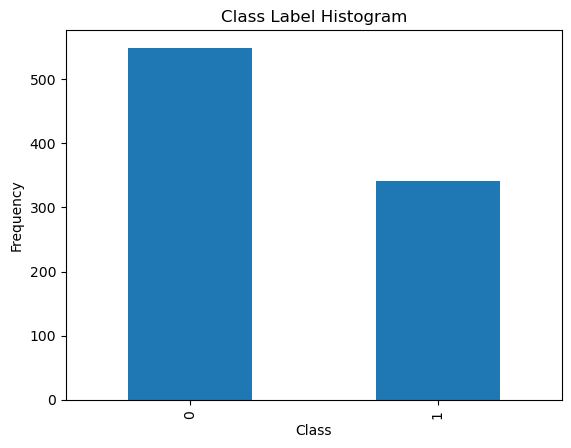

In [2]:
# Plot a frequency histograms for the classes
count_classes = pd.value_counts(raw_training_df['Survived'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("Class Label Histogram")
plt.xlabel("Class")
plt.ylabel("Frequency");

From the histogram above it clear that the dataset contains more negative class labels (non-survivors) than positive (survivors) ones. However, it is not heavily imbalanced and thus we would not expect it to reduce the accuracy of our predictive model.

#Data Pre-Processing


----------


Our dataset contains a lot of information about each passenger. While some information, such as passenger age and their cabin location, may help determine a person's chances of survival, other information, such the passenger name and ticket details, would be futile. Thus, these can be considered as redundant feature labels that could potentially reduce the performance of our model. So, it would be wise to discard the information.

In [3]:
# Remove the 'Name' and 'Ticket' columns from the dataframes 
training_df = raw_training_df.drop(['Name', 'Ticket'], axis=1)

# print(training_df.columns) # List column names (Optional)

The dataset contains a lot of *missing values*. Removing the rows with missing values from the data set would result in significant loss of valuable information. To circumvent this problem, we will insert alternative values into these empty fields.  *Note: There are different ways to handle missing values and the method we choose will have a significant impact on the classifier performance. Therefore, it would be wise to experiment with different methods.* For the sake of simplicity, we will use *mean insertion* for the numeric columns and *fixed-value insertion* for columns containing strings.

In [4]:
# Fill in emtpy fields in the 'Cabin' column with the string 'unknown'
training_df['Cabin'] = training_df['Cabin'].fillna('unknown') # Mean age of the passengers happens to be 30.

In [5]:
# Use the mean 'Age' value for empty fields in the 'Age' column
training_df['Age'] = training_df['Age'].fillna(math.ceil(training_df['Age'].mean()))

# training_df.tail(100) # Show last 100 entries (Optional)

[Lawrence Chernin](https://www.kaggle.com/c/titanic/discussion/7540) has tested the raw dataset using a number of different machine learning methods. In his investigation, Lawrence found that the decision tree classifier works well for this dataset. Therefore, I have gone ahead and chose the classifier.

In order to feed in the data into a decision tree classifier, we need to convert strings into float data types.  Luckily, I found a function, written by [Chris Strelioff](http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html), that achieves this in just a few lines of code. His code looks for unique values in a given column to create categories and encodes the categorical values using numerical values (for detailed explaination see [this](http://www.kdnuggets.com/2015/12/beyond-one-hot-exploration-categorical-variables.html)).

In [6]:
'''
    Credit for the following function goes to Chris Strelioff 
    (http://chrisstrelioff.ws/sandbox/2015/06/08/decision_trees_in_python_with_scikit_learn_and_pandas.html)
'''
def encode_target(df, target_column):
    df_mod = df.copy()
    targets = df_mod[target_column].unique()
    map_to_int = {name: n for n, name in enumerate(targets)}
    df_mod[target_column] = df_mod[target_column].replace(map_to_int)

    return (df_mod, targets) # Returns modified dataframe and an array containing the different values encountered in a column

training_df, sex_targets = encode_target(training_df, "Sex")

training_df, embarked_targets = encode_target(training_df, "Embarked")

training_df, cabin_targets = encode_target(training_df, "Cabin")

# training_df.tail(100) # Display the last 100 entries (Optional)

In [7]:
# Assign class features to the variable 'X'
X = training_df.ix[:, training_df.columns != 'Survived']

# Assign class labels to the variable 'y'
y = training_df.ix[:, training_df.columns == 'Survived']

AttributeError: 'DataFrame' object has no attribute 'ix'

Our test set does not specify which passenger survived and which passenger did not. In order to evaluate the performance of our classifier later, it is necessary to create a *cross-validation set* from the training dataset at this stage. Let's go with a 7:3 split - that is 70% of the training data will be used to train the classier and 30% for evaluating its accuracy. This is an important step as the classifier should not be tested on the data it has already been trained with.

In [ ]:
# Create a cross-validation (CV) set from the existing data set
X_train, X_CV, y_train, y_CV = train_test_split(X,y,test_size = 0.3, random_state = 0)

#Training and Evaluating the Classifier


----------
![KNIME workflow part 2][1]
***Figure 2: The third part of the KNIME workflow diagram highlights the nodes used for evaluating the ML model.*** 





  [1]: https://i.imgur.com/XVm6kRY.png

In [ ]:
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99) # Declare a decision tree clasifier
dt.fit(X_train, y_train) # Fit the classifier to the training set
y_pred = dt.predict(X_CV) # Predict class labels for the cross-validation set

Now that we have trained the classifier and made some predictions for the cross-validation set, we can test the accuracy of the predictions using the following metrics: recall, precision, f1-score and accuracy. In order to calculate these metrics, we require a [confusion matrix](http://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) for the cross-validation dataset predictions.

In [ ]:
'''
    Credit for the following confuction matrix function goes to
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
'''
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_CV, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[0, 1],
                      title='Confusion matrix')

plt.show()

**The metrics were calculated as described below:**

P = precision = true positives / predicted positives

R = recall = true positives / actual positives

f1 = 2 * ((RP)/(R+P))

accuracy = (true positives + true negatives)/total

In [ ]:
prec = cnf_matrix[1,1] / (cnf_matrix[0,1] + cnf_matrix[1,1])
print("The precision of the ML model is ", round(prec, 3))

recl = cnf_matrix[1,1] / (cnf_matrix[1,0] + cnf_matrix[1,1])
print("The recall of the ML model is ", round(recl, 3))

f1 = 2*((recl*prec)/(recl+prec))
print("The f1-score of the ML model is %f." % round(f1, 3))

acc = (cnf_matrix[1,1] + cnf_matrix[0,0]) / ((cnf_matrix[0,1] + cnf_matrix[1,1]) + cnf_matrix[0,0] + cnf_matrix[1,0])
print("The accuracy of the ML model is ", round(acc, 3))

The *precision* metric tells us what proportion of passengers we predicted as having survived actually had survived, while the *recall* gives the proportion of passengers that actually had survived were predicted by us as having survived. An f1-score combines these metrics to create a single value metric. For the current classifier, we have obtained an f1-score of 0.70 and this informs us that our classifier is flagging up true positives reasonably well. The high accuracy metric score of 0.79 indicates that our classifier is reasonably good at identifying true positives and true negatives. Since these metrics are equal to and greater than 0.70, we can go ahead and use this classier to make predictions for the original test dataset.

#So who has survived the shipwreck?


----------
![KNIME workflow part 3][1]
***Figure 3: The final two parts of the KNIME workflow diagram highlights the nodes used in the class prediction and data export operations.*** 


Now that we have a working classifier that yields a reasonable accuracy score, we can predict class labels for the passengers listed in the original test dataset. Above, we have only used a subset of the original training set for training the model. This time will use the whole dataset for training as this could help increase the accuracy of our classifier. Before we feed the data (both training and test) into the classifier, we need to pre-process using the same operations as before. Finally, we can separate the columns in the training set into class features (**X**) and class labels (**y**).


  [1]:https://i.imgur.com/Y4aOBrI.png

In [ ]:
'''
    Before we feed the dataset into the classier,
    Let's define a function that pre-processes it using the same operations.
''' 
def pre_process(df):
    mod_df = df.drop(['Name', 'Ticket'], axis=1)
    mod_df['Cabin'] = df['Cabin'].fillna('unknown')
    mod_df['Fare'] = df['Fare'].fillna(math.ceil(df['Fare'].mean())) # This is a new line see next line for explanation
    mod_df['Age'] = df['Age'].fillna(math.ceil(df['Age'].mean()))
    
    mod_df, sex_targets = encode_target(mod_df, "Sex")
    mod_df, embarked_targets = encode_target(mod_df, "Embarked")
    mod_df, cabin_targets = encode_target(mod_df, "Cabin")
    
    return mod_df # return modified dataframe

# Pre-process the whole training dataset
whole_training_df = pre_process(raw_training_df)
# Remember we need to pre-process the test dataset similarly 
test_df = pre_process(raw_test_df)

# Assign class features to the variable 'X' for training set 
X = whole_training_df.ix[:, whole_training_df.columns != 'Survived']
# Assign class labels to the variable 'y' for training set
y = whole_training_df.ix[:, whole_training_df.columns == 'Survived']

I encountered an error when I attempted to predict classes for the test set, because the **Fare** column contained empty values (i.e. NaN). This was simply resolved by adding an extra line of code to the existing *pre-process*  function in the previous cell.

In [ ]:
# The following code was used to debug the error caused by the test set 

# np.all(np.isfinite(test_df)) # This returned true
# np.any(np.isnan(test_df)) # This returned true
# test_df.isnull().any() # This was used to check for NaN values in all columns

In [ ]:
dt = DecisionTreeClassifier(min_samples_split=20, random_state=99) # Declare a decision tree clasifier
dt.fit(X, y) # Train the classifier using the entire training set
y_pred = dt.predict(test_df) # Predict class labels for test set

# Now lets create a new table for submission to Kaggle accuracy scoring.
# This should only contain the PassengerIds and predicted class labels(Survived).
submission =  pd.DataFrame(
    {'PassengerId': raw_test_df['PassengerId'], 
     'Survived': y_pred
    })

# Save submission file
submission.to_csv("submission_file.csv", sep=',', encoding='utf-8', index=False)
# submission_file.csv will submitted to Kaggle for accuracy evaluation

# Now lets create another table that contains the PassengerIds, Sexes and class labels (Survived).
# This will be used for data visulisation in the next step.
results =  pd.DataFrame(
    {'PassengerId': raw_test_df['PassengerId'], 
     'Sex': raw_test_df['Sex'], 
     'Survived': y_pred
    })

# results.head(100) # Show the table (Optional)

# Save output file
results.to_csv("class_predictions.csv", sep=',', encoding='utf-8', index=False)

# Check the 'Output' tab at the top of the web page to view the csv file.

The submitted predictions scored a Kaggle accuracy score of 0.80383. The 0.01683 increase in the accuracy score clearly indicates that the newly trained classifier is an improvement on the previous classifier, which was trained using only a subset of the training data.

## Data Visualisation 
Using the power of **[Tableau](https://www.tableau.com/)** and the exported CSV output file, I have visualised the class predictions for the passengers listed in the test dataset. I had some difficulties visualising the data, but eventually found a way to condense all of the necessary information in one diagram.

![Class Predictions][1]
***Figure 4: A diagram containing the survival prediction for each passenger in the testing data set and a breakdown of the survivors according to their sexes.*** 

  [1]:https://i.imgur.com/U2aR6SV.png

In **Figure 4**, the PassengerId increases from left to right and from top to bottom: The blue cross at the top left corner represents the first passenger in our test set (PassengerId = 892) and the same symbol located far right in the last row represents the last passenger (PassengerId = 1309). Unfortunately, our classifier predicted that both of them will not have survived the shipwreck. The data visualisation clearly shows that only a small fraction (15/125) of our survivors are males. This is an interesting insight but certainly comes as no surprise, since women and children were given priority to the lifeboats during the Titanic shipwreck. Perhaps in another Kaggle Kernel we could do a little more investigation to test this hypothesis.

#Final Remarks


----------


In this Kernel,  we have written a predictive model with the help of a workflow created in KNIME analytics and the ML model achieved a Kaggle accuracy score of 0.80 (= 80%). This score could be improved by doing a number of things to the model, such as optimising certain classifier parameters or using advanced feature extraction techniques (*i.e.* improving the current pre-processing function). The existing classifier could be suffering from high variance or high bias - we could employ a number of tools to diagnose the issue and subsequently fix it. One could also use a linear combination of different classifiers to achieve really good predictions. According to the [leaderboard](https://www.kaggle.com/c/titanic/leaderboard), there are more sophisticated ML models for this problem that can make predictions with 100% accuracy. 

The only drawback I have experienced with KNIME analytics was that it was relatively slow when compared to Python. However, I found that KNIME's easy-to-use UX and caching abilities compensated well for the slow speed. In this notebook, I have used KNIME's 'ready-made'  *Learner* and *Predictor* workflow nodes and personally, I found it restrictive due to the lack of some adjustable ML parameters (For example, when working with neural networks I was not able to modify the regularisation parameter). Nevertheless, it is possible to create bespoke ML models using the *Python nodes*. I hope I have clearly illustrated how easy it is to translate a workflow into a functional Python script. If used properly KNIME Analytics could be a data analyst's best friend.

*If you have any questions or suggestions for me, please feel free to leave a comment on this Kernel and I will try my best to address it.*